# Import library

In [1]:
import sys
sys.argv = ['jupyter']  # Clear the parameters passed to Jupyter
sys.path.append('../')

In [2]:
import sys
sys.path.append('../')
import time,json,os,re
import spectral_entropy as se
from my_packages import functions_new, peaktools
import numpy as np
import pandas as pd
from tqdm import trange,tqdm
from rdkit import Chem, RDLogger

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


# GNPS library Operation
1. Library
    * GNPS-LIBRARY
    * [GNPS Link](https://external.gnps2.org/gnpslibrary)
2. Spectral type
    * ionnization mode
    * dissociation type
    * instrumental platform
    * collision energy
    * spectral quality
    * preprocess or not

## Preprocess library
1. Convert mgf file to json format (easy access by CCMSID)
2. Clean spectra (1% noise removing, normalizing, truncating precursor)
3. Retrive NPclassifer classes

### MGF converting & Spectrum cleaning

In [4]:
# Converting 'GNPS-LIBRARY.mgf' to json file {CCMSID1:{},CCMSID1:{},...}
# Retain positive
# Load files
DIR = '../msdb/GNPSLIBRARY_250514/'
GNPS_LIBRARY_file = os.path.join(DIR,'GNPS-LIBRARY.mgf') # Download from the GNPS as of 250514
ALL_GNPS_NP_file = os.path.join(DIR,'ALL_GNPS_NO_PROPOGATED.mgf')

# MGF to json, using CCMSID as key
# GNPSLIBRARY_PROCESS = functions_new.MgfProcess(GNPS_LIBRARY_file)
# GNPSLIBRARY_PROCESS = functions_new.MgfProcess(ALL_GNPS_file)

# MGFINFO = GNPSLIBRARY_PROCESS.gnps_mgf_extract() # 
# with open(f'../msdb/GNPSLIBRARY_250514/{os.path.basename(ALL_GNPS_file).split(".")[0]}-INFO.json', 'w') as f:
#     json.dump(MGFINFO, f) 

In [5]:
ALL_GNPS_NP = functions_new.load_spectra_from_file(ALL_GNPS_NP_file)

In [38]:
# Access information
GNPS_INFO = {}
for i in trange(len(ALL_GNPS_NP)):
    SPECTRUM = ALL_GNPS_NP[i]
    METADATA = SPECTRUM.metadata # ionmode,smiles,inchi,precursor_mz,ionmode,spectrum_id
    try:
        if METADATA['ionmode'] == 'positive':
            MZ = SPECTRUM.mz
            INT = SPECTRUM.intensities
            PEAKs = np.column_stack((SPECTRUM.mz,SPECTRUM.intensities))
            PM = METADATA['precursor_mz']
            CHARGE = METADATA['charge']
            IONMODE = METADATA['ionmode']
            try:
                SMILE = METADATA['smiles']
            except:
                SMILE = ''

            GNPS_INFO[CCMSID] = {'pepmass':PM,'charge':CHARGE,'ionmode':IONMODE
                     ,'smiles':SMILE,'inchi':INCHI,'ms2':PEAKs.tolist()}

            if S
            try:
                INCHI = METADATA['inchi']
            except:
                INCHI = ''
            CCMSID = METADATA['spectrum_id']
            
            GNPS_INFO[CCMSID] = {'pepmass':PM,'charge':CHARGE,'ionmode':IONMODE
                                 ,'smiles':SMILE,'inchi':INCHI,'ms2':PEAKs.tolist()}
    except:
        pass

100%|█████████████████████████████████| 908030/908030 [02:57<00:00, 5122.86it/s]


In [42]:
# To MS1 DataFrame
data_list_comprehension = [
    {
        'CCMSID': ccmsid,
        'pepmass': info.get('pepmass'),
        'smiles': info.get('smiles'),
        'inchi': info.get('inchi')
    }
    for ccmsid, info in GNPS_INFO.items()
]

# Create the DataFrame
df_comprehension = pd.DataFrame(data_list_comprehension)
df_comprehension_FILE = os.path.join(DIR,'edbMS1.csv')
df_comprehension.to_csv(df_comprehension_FILE)

In [43]:
# To MS2 JSON
GNPS_INFO_FILE = os.path.join(DIR,'edb_info.json')
with open(GNPS_INFO_FILE, "w") as f:
    json.dump(GNPS_INFO, f)

In [2]:
# Loading the saved library json file
with open('../msdb/GNPSLIBRARY_250514/GNPS-LIBRARY-INFO.json','r') as f:
    GNPS_LIBRARY_INFO = json.load(f)

In [4]:
# Access the library by specific CCMSID, each value of entities is <str> type
CCMSID1 = 'CCMSLIB00000001547'
SPEC1, SPECTRUM1 = functions_new.GNPS_info_format(GNPS_LIBRARY_INFO,CCMSID1)

CCMSID2 = 'CCMSLIB00000001548'
SPEC2, SPECTRUM2 = functions_new.GNPS_info_format(GNPS_LIBRARY_INFO,CCMSID2)


In [15]:
# MS2 comparison
sim = se.similarity(SPEC1, SPEC2, method='bhattacharya_2', ms2_da=0.05)


NL_result = peaktools.neutral_loss(SPECTRUM1, SPECTRUM2,0.05)
MCS_result = peaktools.modified_cosine(SPECTRUM1, SPECTRUM2,0.05)
MCS_result

SimilarityTuple(score=0.023287164760404266, matched_intensity=0.09606859785142204, max_contribution=0.02171764150261879, n_greq_2p=1, matches=4, matched_indices=array([125, 133, 143, 167]), matched_indices_other=array([21, 25, 34, 52]))

## Filtering CCMSIDs
* Generate as '.npy' format
Since spectra have different adducts type,sourced from redundant structures and different instrument platform
It is necessary to remove influences mentioned above before evaluating the spectral similarity matrices

In [ ]:
t = time.time()

# Loading preprocessed json file
gnps_library_file = '../msdb/GNPSLIBRARY_250514/GNPS-LIBRARY-INFO_new.json'
with open(gnps_library_file,'r') as f:
    gnps_info = json.load(f)

# Filtering CCMSIDs by instrument and adduct type
filtered_IDs, ADDUCTs,INSTRUMENTs = [],[],[]
PATTERN = re.compile(r'qtof$', re.IGNORECASE)
for key, value in tqdm(gnps_info.items(),total=len(gnps_info)):
    ADDUCT = value["ADDUCT"]
    ADDUCTs.append(ADDUCT)
    INSTRUMENT = value["INSTRUMENT"]
    INSTRUMENTs.append(INSTRUMENT)
    if ADDUCT == 'M+H' and re.search(PATTERN,INSTRUMENT):
        filtered_IDs.append(key)
        
# Duplicate structures
nonredundant_SMILES = []
nonredundant_IDs = []
for ID in tqdm(filtered_IDs,total=len(filtered_IDs)):
    try:
        SMILE1 = Chem.CanonSmiles(gnps_info[ID]['SMILE'])
        if not nonredundant_SMILES: # append the 1st smile in the empty list
            nonredundant_SMILES.append(SMILE1)
            nonredundant_IDs.append(ID)
        else:
            if Chem.CanonSmiles(SMILE1) not in nonredundant_SMILES:
                nonredundant_SMILES.append(SMILE1)
                nonredundant_IDs.append(ID)
    except:pass

# Saving CCMSIDs 
np.save('H_qtof_non-redundant_CCMSIDs.npy',nonredundant_IDs)

In [ ]:
# Loading CCMSIDs
CCMSIDs = np.load('./H_qtof_CCMSIDs.npy').tolist()
print(len(CCMSIDs))

## Supplement smiles to gnps info

In [4]:
edbms2_file = '../msdb/edb_info.json'
GNPS_INFO = functions_new.json_load(edbms2_file)

gnps_clean_file = '../msdb/FS_edb_smi.json'
GNPS_SMI = functions_new.json_load(gnps_clean_file)

In [ ]:
RDLogger.DisableLog('rdApp.*') # Turn off output of RDkit
KEY_to_SUPP = []
for key, values in tqdm(GNPS_INFO.items(),total = len(GNPS_INFO)): # CCMSLIB00000001547
    mol = Chem.MolFromSmiles(values['smiles'])
    if mol is None:
        KEY_to_SUPP.append(key)


In [32]:
len(KEY_to_SUPP)

3537

In [ ]:
SMI_DICT = {SPECTRUM['id']:SPECTRUM['smile'] for SPECTRUM in GNPS_SMI} # CLEAN

In [31]:
n = 0
for key in KEY_to_SUPP:
    try:
        SMI_DICT['key']
    except:
        n +=1
n

3537

## Supplementing attributes  
### Spectral properties
entropy,n_peaks,adduct,canonsmiles,adducts

In [ ]:
GNPS_JSON = ''../msdb/GNPSLIBRARY_250514/GNPS-LIBRARY-INFO.json''
with open(GNPS_JSON, 'r') as f:
    gnps_info = json.load(f)

idx=0
for key in tqdm(gnps_info.keys(), total=len(gnps_info)):
    spec, spectrum = functions_new.GNPS_info_format(gnps_info, key)
    num_fragments = len(spec)
    entropy = calculate_entropy(spec)
    gnps_info[key]['NUM_FRAGMENTS'] = f'{num_fragments}'
    gnps_info[key]['ENTROPY'] = f'{entropy}'
    gnps_info[key]['ADDUCT'] = gnps_info[key]['NAME'].split()[-1]
    gnps_info[key]['INDEX'] = f'{idx}'
    idx +=1
    try:
        gnps_info[key]['CANONSMILES'] = Chem.CanonSmiles(gnps_info[key]['SMILE'])
    except:
        gnps_info[key]['CANONSMILES'] = 'nah'
        
with open('../msdb/GNPSLIBRARY_250514/GNPS-LIBRARY-INFO_new.json', 'w') as f1: # be different with the original json file or overwrite mistake happens 
    json.dump(gnps_info, f1)

### Properties of structures behind spectra
NPclassifier class supplement
#### 1. Converting coconut csv file to json format, with CanonSmiles as keys Supplementing by CanonSmiles keys

In [ ]:
# Load GNPS dataset
gnps_file = '../msdb/GNPSLIBRARY_250514/GNPS-LIBRARY-INFO.json'
with open(gnps_file,'r') as f:
    gnps_info = json.load(f)

# Load COCONUT csv
COCONUT_file = '../msdb/COCONUT_2506/coconut_csv_lite-06-2025.csv'
COCONUT_DF = pd.read_csv(COCONUT_file)

# Convert COCONUT csv to json, using CANONSMILES as key for quick accession
COCONUT_DICT={}
for index, row in tqdm(COCONUT_DF.iterrows(),total=len(COCONUT_DF)):
    try:
        CANONSMILE = Chem.CanonSmiles(row['canonical_smiles'],useChiral=0)
        COCONUT_DICT[CANONSMILE] = {'np_classifier_superclass': row['np_classifier_superclass'],
                                             'np_classifier_class':row['np_classifier_class']}
    except:pass
with open('../msdb/COCONUT_2506/COCONUT.json','w') as f:
    json.dump(COCONUT_DICT,f)

# Supplement gnps_info
with open('../msdb/COCONUT_2506/COCONUT.json','r') as f1:
    COCONUT_INFO = json.load(f1)

for key, value in tqdm(gnps_info.items(), total=len(gnps_info)):
    try:
        SMILE1 = value['CANONSMILES']
        value['np_classifier_superclass'] = COCONUT_INFO[SMILE1]['np_classifier_superclass']
        value['np_classifier_class'] = COCONUT_INFO[SMILE1]['np_classifier_class']
    except:pass

with open('../msdb/GNPSLIBRARY_250514/GNPS-LIBRARY-INFO_new.json', 'w') as f:
    json.dump(gnps_info, f)

#### 2. Requset from GNPS2 API

In [19]:
import sys
sys.path.append('../')
import time,json,requests
import numpy as np
import pandas as pd
from rdkit import Chem
from tqdm import tqdm, trange
from my_packages import functions_new, cheminfo_tools

In [5]:
# Load gnps library
gnps_file = '../msdb/GNPSLIBRARY_250514/GNPS-LIBRARY-INFO.json'
with open(gnps_file,'r') as f:
    gnps_info = json.load(f)

In [ ]:
# Request and save as dict(CCMSID as ky)
ToSup = np.load('../msdb/data/idlist/NpclasstoSupplement.npy')
print(len(ToSup))
failed_list = []
dict ={}
for CCMSID in tqdm(ToSup,total=len(ToSup)):
    try:
        SMILE1 = gnps_info[CCMSID]['CANONSMILES']
        dict[CCMSID] = cheminfo_tools.NPclass_request(SMILE1)['superclass_results']
        # gnps_info[CCMSID]['np_classifier_superclass'] = cheminfo_tools.NPclass_request(SMILE1)['superclass_results']
        # # value['np_classifier_class'] = COCONUT_INFO[SMILE1]['np_classifier_class']
    except:failed_list.append(CCMSID)

with open('../msdb/data/idlist/NpclasstoSupplement.json','w') as f:
    json.dump(dict,f)
    
# np.save('../msdb/data/idlist/failedCCMSID.npy', failed_list)

In [ ]:
with open('../msdb/data/idlist/NpclasstoSupplement.json','r') as f:
    json.dump(dict,f)
    print(len(f))

In [ ]:
# Supplement
# # 1 via json,some requset will success at second time 
# with open('toSupplement.json','r') as f:
#     sup_info = json.load(f)
# for key, value in sup_info.items():
#     gnps_info[key]['np_classifier_superclass'] = value

# 2 via csv, collect manully
df = pd.read_csv('../msdb/data/idlist/NpclasstoSupplement.csv')
for idx, row in df.iterrows():
    ccmsid = row['ccmsid']
    NPsuperclass = row['superclass']
    gnps_info[ccmsid]['np_classifier_superclass'] = NPsuperclass

# del gnps_info["np_classifier_superclass"]
with open('../msdb/GNPSLIBRARY_250514/GNPS-LIBRARY-INFO.json', 'w') as f:
    json.dump(gnps_info, f)

#### 3. Check missing NPclassifier classes

In [35]:
# Check missing
CCMSIDs = np.load('../msdb/data/idlist/H_qtof_non-redundant_CCMSIDs.npy')
list = []
for CCMSID in CCMSIDs:
    try:
        test = gnps_info[CCMSID]['np_classifier_superclass']
    except:
        list.append(CCMSID)
np.save('../msdb/data/idlist/NpclasstoSupplement.npy',list)
len(list)

0

In [27]:
# Collect NPclassifer superclass manually via （https://npclassifier.ucsd.edu/）
ccmsidlist = np.load('../msdb/data/idlist/NpclasstoSupplement.npy')
ccmsids, canonsmiles = [],[]
for ccmsid in ccmsidlist:
    smile = gnps_info[ccmsid]['CANONSMILES']
    ccmsids.append(ccmsid)
    canonsmiles.append(smile)
df = pd.DataFrame({'ccmsid':ccmsids,'canonsmiles':canonsmiles})
df.to_csv('../msdb/data/idlist/NpclasstoSupplement.csv')

## Statistics
### Instrument

In [1]:
import sys
sys.path.append('../')
import json
from collections import Counter
from my_packages import functions_new
from tqdm import tqdm, trange
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load gnps-library
info_file = '../msdb/GNPSLIBRARY_250514/GNPS-LIBRARY-INFO.json'
gnps_info = functions_new.json_load(info_file)

In [6]:
# Statistics
ADDUCTs,INSTRUMENTs,ENTROPYs,N_FRAGMENTs = [],[],[],[]
for key, value in tqdm(gnps_info.items(),total = len(gnps_info)):
    try:
        ADDUCTs.append(value['ADDUCT'])
        INSTRUMENTs.append(value['INSTRUMENT'])
        N_FRAGMENTs.append(value['NUM_FRAGMENTS'])
        ENTROPYs.append(value['ENTROPY'])
    except:
        print(value)

100%|█████████████████████████████████| 15254/15254 [00:00<00:00, 714372.47it/s]

['Tryptophan alkaloids']


In [9]:
# Statistics of adducts/instruments
ADDUCT_statics = Counter(ADDUCTs)
top9_adducts = ADDUCT_statics.most_common(9)
other_adducts = sum(ADDUCT_statics.values()) - sum(count for _, count in top9_adducts)

top9_adducts, other_adducts

([('M+H', 9656),
  ('M-H', 1998),
  ('M+Na', 1478),
  ('M-H2O+H', 253),
  ('M+NH4', 240),
  ('2M+Na', 224),
  ('2M+H', 199),
  ('M+K', 173),
  ('M+H-H2O', 166)],
 866)

In [21]:
PRECURSORs, ENTROPYs, N_FRAGMENTs = [],[],[]
for key, value in tqdm(gnps_info.items(),total = len(gnps_info)):
    try:
        if value['ADDUCT'] == 'M+H':
            PRECURSORs.append(float(value['PEPMASS']))
            N_FRAGMENTs.append(int(value['NUM_FRAGMENTS']))
            ENTROPYs.append(float(value['ENTROPY']))
                    
    except:
        print(value)

100%|█████████████████████████████████| 15254/15254 [00:00<00:00, 579864.35it/s]

['Tryptophan alkaloids']


/var/folders/jn/9w7jb7xs59q_4h4hy8w5lchh0000gn/T/ipykernel_27322/2618138891.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y=PRECURSORs,x=ENTROPYs,shade = True,color ='red')


(0.0, 1500.0)

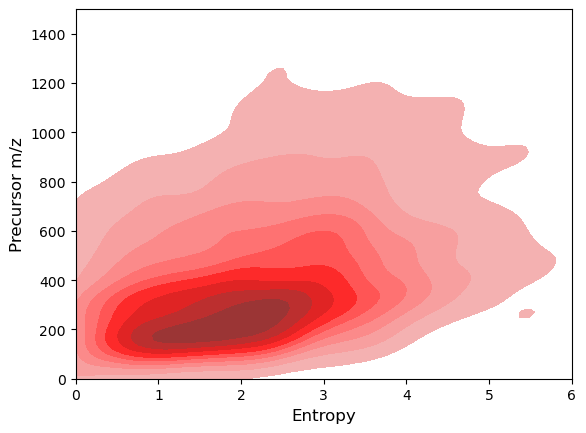

In [27]:
sns.kdeplot(y=PRECURSORs,x=ENTROPYs,shade = True,color ='red')
plt.xlabel('Entropy', fontsize=12) 
plt.ylabel('Precursor m/z', fontsize=12) 
plt.xlim(0, 6) 
plt.ylim(0, 1500) 

/var/folders/jn/9w7jb7xs59q_4h4hy8w5lchh0000gn/T/ipykernel_27322/2822233901.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y=N_FRAGMENTs,x=ENTROPYs,shade = True,color ='blue')


(0.0, 400.0)

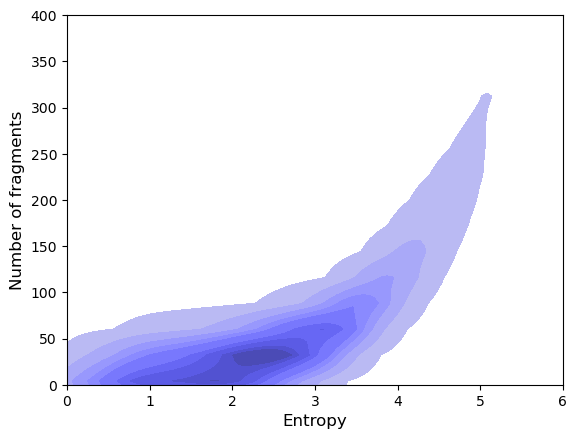

In [29]:
sns.kdeplot(y=N_FRAGMENTs,x=ENTROPYs,shade = True,color ='blue')
plt.xlabel('Entropy', fontsize=12) 
plt.ylabel('Number of fragments', fontsize=12) 
plt.xlim(0, 6) 
plt.ylim(0, 400) 